In [1]:
from qiskit import QuantumCircuit, QuantumRegister

##### Build a circuit with Qiskit

In [30]:
qubits = QuantumRegister(2, name='q')
circuit = QuantumCircuit(qubits)

In [31]:
q0, q1 = qubits
circuit.h(q0)
circuit.cx(q0, q1)
circuit.measure_all()

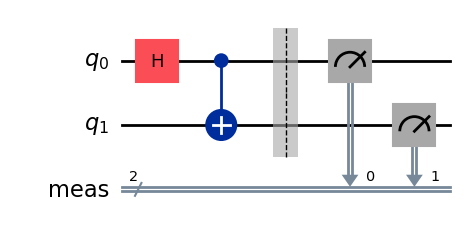

In [32]:
circuit.draw('mpl')

#### Transpile a circuit

In [21]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService #, SamplerV2

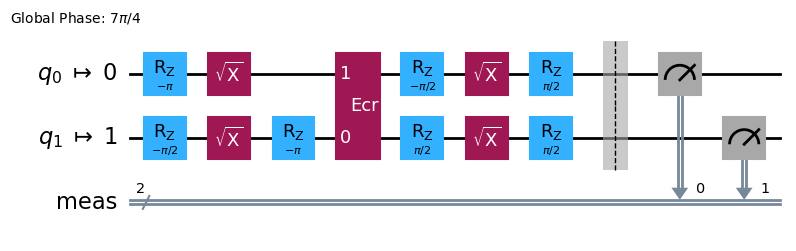

In [22]:
service = QiskitRuntimeService()
backend = service.backend('ibm_brisbane')
pass_manager = generate_preset_pass_manager(1, backend=backend)
transpiled = pass_manager.run(circuit)

transpiled.draw('mpl', idle_wires=False)

#### Simulation tools - fake backends

In [34]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Run the sample job locally using FakeManilaV2
fake_manila = FakeManilaV2()
pm = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)
isa_qc = pm.run(circuit)

# You can use a fixed seed to get fixed results
options = {'simulator': {'seed_simulator': 42}}
sampler = Sampler(fake_manila)

result = sampler.run([isa_qc]).result()

# NOTE: something didn't work, probably due to deprecation

/Users/kaskadermike/opt/anaconda3/envs/qc-qiskit/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/fake_backend.py:468: RuntimeWarning: Aer not found, using qiskit.BasicSimulator and no noise.
  warnings.warn(


#### Test primitives

##### Sample primitive

In [27]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.quantum_info import random_hermitian
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Initialize the Qiskit Runtime service
service = QiskitRuntimeService()

# Choose a hardware backend
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)

n_qubits = 127

mat = np.real(random_hermitian(n_qubits, seed=1234))
circuit = IQP(mat)
circuit.measure_all()

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
# Instruction Set Architecture (ISA) — i.e., the set of instructions the device can understand and execute.
isa_circuit = pm.run(circuit) 

# Initialize a Qiskit Runtime primitive with a chosen backend
sampler = Sampler(backend)
# Invoke the primitive with your circuit
job = sampler.run([isa_circuit])
result = job.result()

##### Estimator primitive

In [35]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from traitlets import observe

# Initialize the Qiskit Runtime service
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
estimator = Estimator(backend)

n_qubits = 127

mat = np.real(random_hermitian(n_qubits, seed=1234))
# a single circuit without a measurement
circuit = IQP(mat)
# one or more observables
observable = SparsePauliOp('Z' * n_qubits)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

# you can also add parameters, and group the together within a PUB
job = estimator.run([(isa_circuit, isa_observable)])    # -> grouping of circuit and observable is a PUB - primitive unified block
result = job.result()

print(f' > Expectation value: {result[0].data.evs}')
print(f' > Metadata: {result[0].metadata}')

 > Expectation value: 0.01953125
 > Metadata: {'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32}


##### Estimator primitive from Qiskit Aer

In [37]:
from qiskit_aer.primitives import Estimator

qubits = QuantumRegister(2, name='q')
circuit = QuantumCircuit(qubits)

q0, q1 = qubits
circuit.h(q0)
circuit.cx(q0, q1)
# no measurements because we're using the Estimator primitive

observable = SparsePauliOp('ZZ')

estimator = Estimator()
job = estimator.run(circuit, observable)
exact_value = job.result().values[0]

print(exact_value)


1.0


#### Noise models with Qiskit Aer

In [ ]:
from qiskit_aer.noise import NoiseModel, ReadoutError, depolarizing_error

service = QiskitRuntimeService()
backend = service.backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(backend)

estimator = Estimator(backend_options=dict(noise_model=noise_model))

In [43]:
from qiskit_aer.noise import ReadoutError, depolarizing_error

noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
bit_flip_prob = 0.05
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ['cx'])

noise_model.add_all_qubit_readout_error(
    ReadoutError([[1 - bit_flip_prob, bit_flip_prob],
                 [bit_flip_prob, 1 - bit_flip_prob]]))

##### Stabilizer circuit

In [44]:
estimator = Estimator(backend_options=dict(method='stabilizer'))

#### Run a circuit on quantum hardware using Qiskit Runtime

In [57]:
from qiskit_ibm_runtime import Estimator

# Initialize Qiskit Runtime service
service = QiskitRuntimeService()
backend = service.backend('ibm_brisbane')

# Create a circuit and observable
n_qubits = 127
mat = np.real(random_hermitian(n_qubits, seed=1234))
circuit = IQP(mat)
observable = SparsePauliOp('Z' * n_qubits)

# Initialize the Estimator primitive
estimator = Estimator(mode=backend)

# # Invoke the Extimator and get results
# job = estimator.run([(circuit, observable)])
# result = job.result()

# print(result)

# NOTE: couldn't run the example, some issues with the Estimator